In [1]:
# # install required packages
# !pip install yfinance --upgrade --no-cache-dir

# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# 오늘 날짜를 구하자
today = dt.date.today()
# delta = 1 day time delta
delta = dt.timedelta(days = 1)
# 마지막 델타 = 10년 전
end_delta = dt.timedelta(days = 3652)

# 샘플의 끝을 어제로 설정
end_of_sample = (today - delta)
# 시작을 10년전 샘플의 시작으로 설정
start_of_sample = (end_of_sample - end_delta)

# 'datetime'의 데이터 형태를 야후 파이낸스가 해석할 수 있는 문자열로 변환
end_of_sample = end_of_sample.isoformat()
start_of_sample = start_of_sample.isoformat()

In [4]:
# Datreader를 이용해 S&P500 데이터 임포트 (정의된 기간)
from pandas_datareader import data as pdr
dataset = pdr.get_data_yahoo("^GSPC", start=start_of_sample, end=end_of_sample).reset_index()
#view rawpanda

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [5]:
# 알고리듬이 매수 주문 또는 매도 주문을 발행하는 조건을 정의
count = int(np.ceil(len(dataset) * 0.1))

action = pd.DataFrame(index=dataset.index)
action['trigger'] = 0.0
action['trend'] = dataset['Adj Close']

action['RollingMax'] = (action.trend.shift(1).rolling(count).max())
action['RollingMin'] = (action.trend.shift(1).rolling(count).min())

action.loc[action['RollingMax'] < action.trend, 'trigger'] = -1
action.loc[action['RollingMin'] > action.trend, 'trigger'] = 1


In [31]:
# 다음이 알고리듬 결정 함수이다.
def trade(price_change, trigger, capital = 10_000, maximum_long = 1, maximum_short = 1,):
    """
    price_change = S&P500 가격변화(S&P500 price change) (절대값)
    trigger = 1은 매수주문, -1은 매도 주문
    capital = 알고리듬에 할당된 최초 자본 (_은 큰 값에 대해 쉼표 역할)
    maximum_long = the maximum quantity that can be purchased in any one action
    maximum_short = maximum quantity that can be sold in any one action (note the shortselling restriction)
    """
    starting_capital = capital
    sell_states = []
    buy_states = []
    inventory = 0
    print(starting_capital)

    def buy(i, capital, inventory):
        shares = capital // price_change[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough capital to buy a unit price %f'
                % (i, capital, price_change[i])
            )
        else:
            if shares > maximum_long:
                buy_units = maximum_long
            else:
                buy_units = shares
            capital -= buy_units * price_change[i]
            inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * price_change[i], capital)
            )
            buy_states.append(0)
        return capital, inventory

    for i in range(price_change.shape[0] - int(0.025 * len(dataset))):
        state = trigger[i]
        if state == 1:
            capital, inventory = buy( i, capital, inventory)
            buy_states.append(i)
        elif state == -1:
            if inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if inventory > maximum_short:
                    sell_units = maximum_short
                else:
                    sell_units = inventory
                inventory -= sell_units
                total_sell = sell_units * price_change[i]
                capital += total_sell
                try:
                    invest = (
                        (price_change[i] - price_change[buy_states[-1]])
                        / price_change[buy_states[-1]]) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, capital))
            sell_states.append(i)
            
    invest = ((capital - starting_capital) / starting_capital) * 100
    total_gains = capital - starting_capital
    return buy_states, sell_states, total_gains, invest

In [32]:
# 결정 함수에 인수를 전달
buy_states, sell_states, total_gains, invest = trade(dataset['Adj Close'], action['trigger'])

10000
day 286: cannot sell anything, inventory 0
day 287: cannot sell anything, inventory 0
day 288: cannot sell anything, inventory 0
day 290: cannot sell anything, inventory 0
day 298: cannot sell anything, inventory 0
day 300: cannot sell anything, inventory 0
day 301: cannot sell anything, inventory 0
day 302: cannot sell anything, inventory 0
day 307: cannot sell anything, inventory 0
day 312: cannot sell anything, inventory 0
day 421: cannot sell anything, inventory 0
day 422: cannot sell anything, inventory 0
day 426: cannot sell anything, inventory 0
day 427: cannot sell anything, inventory 0
day 502: cannot sell anything, inventory 0
day 506: cannot sell anything, inventory 0
day 509: cannot sell anything, inventory 0
day 510: cannot sell anything, inventory 0
day 511: cannot sell anything, inventory 0
day 512: cannot sell anything, inventory 0
day 513: cannot sell anything, inventory 0
day 514: cannot sell anything, inventory 0
day 515: cannot sell anything, inventory 0
day 5

In [33]:
# 인덱스 수익률을 생성하는 함수
def Index_Returns(start_value, end_value):
    return (((end_value - start_value) / start_value) -1) * 100

# 이 함수에 원하는 인수를 삽입해 샘플 수익률을 계산한다.
SP_500_Returns = Index_Returns(dataset['Adj Close'].iloc[0], dataset['Adj Close'].iloc[-1])

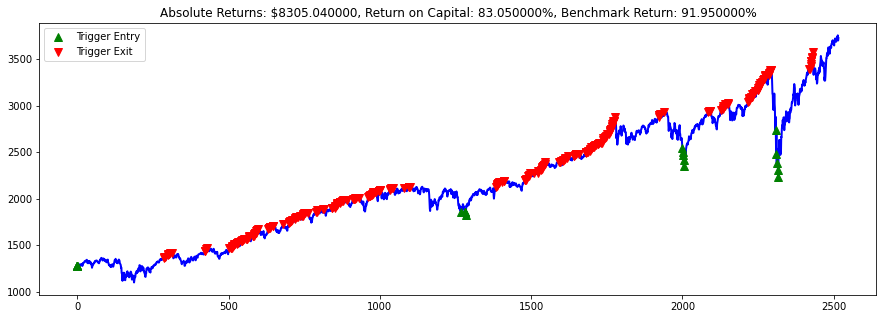

In [34]:
# S&P500 종가 그래프
value = dataset['Adj Close']
fig = plt.figure(figsize = (15,5))
plt.plot(value, color='b', lw=2.)

# 알고리듬에 의해 생성하는 진입/청산 시그널 그래프
plt.plot(value, '^', markersize=8, color='g', label = 'Trigger Entry', markevery = buy_states)
plt.plot(value, 'v', markersize=8, color='r', label = 'Trigger Exit', markevery = sell_states)

# 제목, 절대수익률, 자본수익률과 벤치마크 수익률
plt.title('Absolute Returns: $%f, Return on Capital: %f%%, Benchmark Return: %f%%'%(round(total_gains,2), round(invest,2), round(SP_500_Returns,2)))
plt.legend()
plt.show();